In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys 
sys.path.append("")

In [5]:
from pathlib import Path

import jax
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from idiots.dataset.dataloader import DataLoader
from idiots.experiments.grokking.training import restore, eval_step
from idiots.utils import metrics
import neural_tangents as nt
from einops import rearrange
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from functools import partial

ModuleNotFoundError: No module named 'idiots'

In [ ]:
checkpoint_dir = Path("../../logs/division/exp21/checkpoints")
batch_size = 512


def eval_checkpoint(step):
    config, state, ds_train, ds_test = restore(checkpoint_dir, step)

    def eval_loss_acc(ds):
        for batch in DataLoader(ds, batch_size):
            logs = eval_step(state, batch, config.loss_variant)
            metrics.log(**logs)
        [losses, accuracies] = metrics.collect("eval_loss", "eval_accuracy")
        loss = jnp.concatenate(losses).mean().item()
        acc = jnp.concatenate(accuracies).mean().item()
        return loss, acc

    train_loss, train_acc = eval_loss_acc(ds_train)
    test_loss, test_acc = eval_loss_acc(ds_test)

    return state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc

In [ ]:
data = []
for step in range(0, 50000, 1000): # CHANGE TO 50000
    state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc = eval_checkpoint(step)
    data.append(
        {
            "step": step,
            "state": state,
            "ds_train": ds_train, 
            "ds_test": ds_test,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
    )

CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12030, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<Axes: xlabel='step', ylabel='accuracy'>

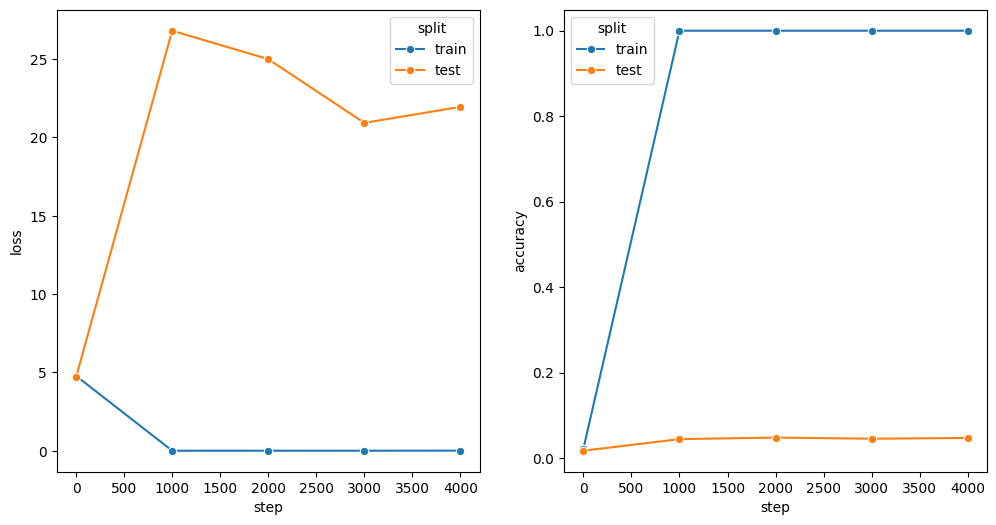

In [ ]:
df = pd.DataFrame(data)

df_loss = df[["step", "train_loss", "test_loss"]]
df_loss = df_loss.melt("step", var_name="split", value_name="loss")
df_loss["split"] = df_loss["split"].str.replace("_loss", "")


df_acc = df[["step", "train_acc", "test_acc"]]
df_acc = df_acc.melt("step", var_name="split", value_name="accuracy")
df_acc["split"] = df_acc["split"].str.replace("_acc", "")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_loss, x="step", y="loss", hue="split", marker="o", ax=axs[0])
sns.lineplot(data=df_acc, x="step", y="accuracy", hue="split", marker="o", ax=axs[1])

In [ ]:
@jax.jit
def main(): 
  df = pd.DataFrame(data)
  state_checkpoints = df['state'].tolist()
  test_data_checkpoints = df['ds_test'].tolist()

  accuracy_checkpoints = [] 

  N = 100
  assert(len(N * 2 < test_data_checkpoints[0]['x']))

  X_train = test_data_checkpoints[0]['x'][0:N]
  Y_train = test_data_checkpoints[0]['y'][0:N]

  X_test = test_data_checkpoints[0]['x'][N:2*N]
  Y_test = test_data_checkpoints[0]['y'][N:2*N]

  for i in range(len(state_checkpoints) - 5, len(state_checkpoints)):
    
    state = state_checkpoints[i - 5]

    kernel_fn = nt.empirical_kernel_fn(state.apply_fn)

    def custom_kernel(X1, X2): 
      return kernel_fn(X1, X2, "ntk", state.params)

    svc = SVC(kernel=custom_kernel)

    svc.fit(X_train, Y_train)

    predictions = svc.predict(X_test)
    accuracy = accuracy_score(Y_test, predictions)

    accuracy_checkpoints.append(accuracy)

  print(accuracy_checkpoints)

main()

NameError: name 'jax' is not defined